In [1]:
import cv2
import os
import sys
import numpy as np
import pickle
from random import randint
import matplotlib.pyplot as plt
import socket
from pathlib import Path
from time import time
from cav.parameters import Parameters
from cav.visualization import Map, plotBoxes
from deep_sort import nn_matching
from deep_sort.tracker import Tracker
from deep_sort.detection import Detection
%matplotlib inline
import project_config as config


In [2]:
TOPOINT = 'BC'

In [3]:
from courtvisionlib.helper import ImageEncoder, create_box_encoder

2025-10-21 22:59:04.197598: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-21 22:59:04.235956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-21 22:59:04.236992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-21 22:59:05.429630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
image_encoder = ImageEncoder(config.ENCODER_PATH, config.ENCODER_INPUT_NAME, config.ENCODER_OUTPUT_NAME)
encoder = create_box_encoder(config.ENCODER_PATH, batch_size=32)

In [5]:
max_cosine_distance = 0.2
nn_budget = 100

metric = nn_matching.NearestNeighborDistanceMetric(
    "cosine", max_cosine_distance, nn_budget)

✅ Perspective transform matrices generated successfully.
ℹ️ Latitude/Longitude mapping skipped (not needed for HoopStats).


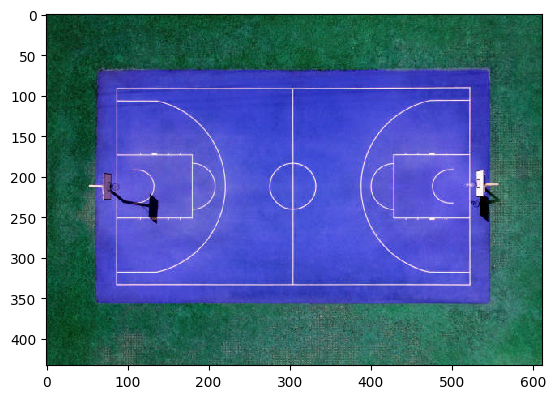

In [6]:
params = Parameters()
params.generateParameters('./params.json')
mymap = Map('./images/Sky View.jpg', './icons_simple.json', params)
plt.imshow(mymap.getMap(), interpolation='nearest')
plt.show()

In [9]:
from cav.Zones import Zones
zones_controller = Zones('./images/mask_org.png', params=params)

In [10]:
SAVE_DETECTIONS = os.path.join(config.DATA_PATH, 'detections.p')
FRAME_FOLDER = os.path.join(config.DATA_PATH, 'frames_raw/')
VIDEO_FILE = pickle.load(open(f'{config.DATA_PATH}/videopath.p', 'rb'))
print ('Video path:', VIDEO_FILE)

Path(FRAME_FOLDER).mkdir(parents=True, exist_ok=True)

save_detections = pickle.load(open(SAVE_DETECTIONS,'rb'))

Video path: Q1_side_30-60.mp4


In [ ]:
SAVE_LOG = None #### Saves logs with all detected objects (path to file or none)

SAVE_ZONES = None 
SAVE_ZONES = os.path.join(config.DATA_PATH, 'zones_detections.csv') 

SKIP_FIRST = 0 # How many seconds in the beginning should be skipped

In [15]:
cap = cv2.VideoCapture(VIDEO_FILE) 
FRAMES_SEC = cap.get(cv2.CAP_PROP_FPS)
VIDEO_X = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
VIDEO_Y = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 


MAX_BOXES_TO_DRAW = 100
MIN_SCORE_THRESH = 0.5
IOU_COMMON_THRESHOLD = 0.50
NOT_DETECTED_TRHESHOLD = 1

MAPSHAPE = mymap.getMap().shape
print ('Y dimension of map is {:.3f} larger than Y dimension of the video'
      .format(MAPSHAPE[0] / VIDEO_Y))

MAP_RESIZE = 3

print ('Y dimension of map is {:.3f} larger than Y dimension of the video. Size of the map is reduced {} times.'
      .format(MAPSHAPE[0] / VIDEO_Y, MAP_RESIZE))


FINAL_X = VIDEO_X + int(MAPSHAPE[1] / MAP_RESIZE)
FINAL_Y = max(VIDEO_Y, int(MAPSHAPE[0] / MAP_RESIZE))

print ('Video size: [{}, {}], Final size: [{}, {}]'
      .format(VIDEO_X, VIDEO_Y, FINAL_X, FINAL_Y))

RESIZE = False


CROP_VID = False
VID_LEFT = 0
VID_RIGHT = 1920
VID_UP = 0


Y dimension of map is 0.200 larger than Y dimension of the video
Y dimension of map is 0.200 larger than Y dimension of the video. Size of the map is reduced 3 times.
Video size: [3840, 2160], Final size: [4044, 2160]


In [16]:
print (MAPSHAPE[0] / VIDEO_Y)

0.20046296296296295


In [ ]:
cap = cv2.VideoCapture(VIDEO_FILE) 

fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = None

objects = []

results = []
colors = {}


tracker = Tracker(metric)



nr_skipped = 0
i = 0
t = time()

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    
    if SAVE_ZONES is not None:
        logfile_zones = open('{}'.format(SAVE_ZONES), 'w')

    while cap.isOpened():
        t2 = time() - t
        sys.stdout.write('{} frames done in {:.1f} seconds ({:.2f} frames/sec)    \r'.format(
            i, t2, i/t2))                   
        
        
        frame_timeStamp = i/FRAMES_SEC
        
        ret, image = cap.read()

        if i < SKIP_FIRST * FRAMES_SEC:
            i += 1
            continue
                
        
        if CROP_VID:
            image = image[VID_UP:, VID_LEFT:VID_RIGHT, :]
        
        if i+1 not in save_detections:
            break
        
        boxes, scores, classes = save_detections[i+1] 
        
        if len(boxes) >= 1:
            for box in boxes:
                if TOPOINT != 'BC':
                    box.setToPoint(TOPOINT)
                    
                box.updateParams(params)
                
            boxes_array = [[box.xLeft, box.yTop, box.xRight - box.xLeft, box.yBottom - box.yTop] for box in boxes]
            boxes_array = np.array(boxes_array)
            bgr_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            features = encoder(bgr_image, boxes_array)
            detections = []

            for box, score, objClass, f_vector in zip(boxes, scores, classes, features):
                detection = Detection(
                    [box.xLeft, box.yTop, box.xRight - box.xLeft, box.yBottom - box.yTop], #BBox
                    score, f_vector,
                    objClass
                )
                detection.bbox = box
                detections.append(detection)

            tracker.predict()
            tracker.update(detections)                
            
        else:
            tracker.predict()
            
        plotboxes = []
        plotcolors = []
        objects = []

        if len(tracker.tracks) >= 1:
            for track in tracker.tracks:
                if not track.is_confirmed() or track.time_since_update >= 1:
                    continue

                obj = track.trackedObject

                if obj is not None:
                    if obj.color is None:
                        obj.color = (randint(0, 255), randint(0, 255), randint(0, 255))                        
                    plotbox = obj.bboxes[-1]
                    plotbox.trackId = track.track_id
                    plotboxes.append(plotbox)
                    plotcolors.append(obj.color)
                    objects.append(obj)
                    
                    if SAVE_ZONES is not None:
                        zone = zones_controller.addObject(obj)
                        if SAVE_ZONES is not None:
                            log_line = '{},{},{}'.format(i, zone, obj.getParams(asCsv=True, speedLookback = 10))
                            print(log_line,file=logfile_zones)                              

                                                         
            if len(plotboxes) >= 1:
                vid = plotBoxes(image, plotboxes, colors=plotcolors)
            else:
                vid = image.copy()
            cv2.imwrite(os.path.join(FRAME_FOLDER, 'im_{}.jpg'.format(str(i).zfill(6))), vid)


                
        if len(objects) > 0:
                                
            if SAVE_LOG is not None:
                logfile = open('./logs/{}'.format(SAVE_LOG, 'w'))
                for obj in objects:
                    line = '{},{},{}'.format(i,time(),obj.getParams(asCsv=true))                               
                    print(line,file=logfile)                    
                                
        i = i+1
                
            
                        
t = time() - t                             
print('\n\n{} frames done in {:.1f} seconds ({:.2f} frames/sec)'.format(
    i, t, i/t))                             
cap.release()
    
